# Customer Segmentation

### Data Wrangling

### Import required libraries

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams.update({'figure.figsize': (7, 5), 'figure.dpi': 100})
sns.set_style("whitegrid")
sns.set()

### Read csv and load data

In [97]:
df = pd.read_csv("online_retail_II.csv")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/10 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/10 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/10 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/10 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/10 08:26,3.39,17850.0,United Kingdom


### Get some information about data 
### i.e column names , thier data types , number of records

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Description  540456 non-null  object 
 3   Quantity     541910 non-null  int64  
 4   InvoiceDate  541910 non-null  object 
 5   Price        541910 non-null  float64
 6   Customer ID  406830 non-null  float64
 7   Country      541910 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Get shape of dataframe

In [99]:
features = ["Invoice", "StockCode", "Description", "Quantity",
            "InvoiceDate", "Price", "Customer ID", "Country"]

rows, cols = df.shape
print("Rows :", rows)
print("Columns :", cols)

Rows : 541910
Columns : 8


# 1. Data Preprocessing

### Lets find and handle missing values

In [100]:
# Get missing values
def get_missing_data(data):
    # Get total number of missing values in each variable
    total = data.isnull().sum().sort_values(ascending=False)

    # Get percentage of missing values
    percent = ((data.isnull().sum()/data.isnull().count())
               * 100).sort_values(ascending=False)

    # Create dataframe for missing data
    missing_data = pd.concat([total, percent], axis=1,
                             keys=["Total", "Percent (%)"])
    return missing_data.style.background_gradient(cmap="Blues")


missing_data = get_missing_data(df)
missing_data

,Total,Percent (%)
Customer ID,135080,24.926648
Description,1454,0.268310
Invoice,0,0.000000
StockCode,0,0.000000
Quantity,0,0.000000
InvoiceDate,0,0.000000
Price,0,0.000000
Country,0,0.000000


### Since we have 25% of missing values in Customer ID feature,Lets remove those records, since Customer ID is important feature we cant delete entire column

In [101]:
df.dropna(axis=0, inplace=True)
missing_data = get_missing_data(df)
missing_data

,Total,Percent (%)
Invoice,0,0.000000
StockCode,0,0.000000
Description,0,0.000000
Quantity,0,0.000000
InvoiceDate,0,0.000000
Price,0,0.000000
Customer ID,0,0.000000
Country,0,0.000000


### Lets find and remove the duplicates

In [102]:
df.duplicated().sum()

5225

### As we can see we have total 5268 duplicate records, its better to remove them

In [103]:
df.drop_duplicates(subset=features, keep=False, inplace=True)
df.duplicated().sum()

# Lets get dimensions of filtered data
df.shape

(396768, 8)

In [104]:
df.describe()

,Quantity,Price,Customer ID
count,396768.000000,396768.000000,396768.000000
mean,12.298885,3.487089,15275.101976
std,251.780854,70.187364,1714.404737
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13919.000000
50%,5.000000,1.950000,15132.000000
75%,12.000000,3.750000,16779.000000
max,80995.000000,38970.000000,18287.000000


## Observations:
### From above stats, minimum amount of quantity ordered is negative which is not possible. So lets make our dataset clean by handling these negative values

In [105]:
df = df[df["Quantity"] > 0]
df.describe()

,Quantity,Price,Customer ID
count,387924.000000,387924.000000,387924.000000
mean,13.278585,3.134669,15281.614290
std,182.689972,22.376584,1713.957221
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13941.000000
50%,6.000000,1.950000,15144.000000
75%,12.000000,3.750000,16788.000000
max,80995.000000,8142.750000,18287.000000


In [106]:
df.shape

(387924, 8)

### Handle canceled transactions

In [107]:
invoices = df['Invoice']
x = invoices.str.contains('C', regex=True)
x.fillna(0, inplace=True)
x = x.astype(int)
df['Order_Canceled'] = x
df['Order_Canceled'].value_counts()
df.reset_index(drop=True,inplace=True)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Order_Canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/10 08:26,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,01/12/10 08:26,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/10 08:26,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/10 08:26,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/10 08:26,3.39,17850.0,United Kingdom,0


# 2. EDA - Exploratory Data Analysis

### Now lets perform the EDA

## 1. How many different transactions, unique customers and different countries are there?

In [108]:
transactions = len(df["Invoice"].value_counts())
customers = len(df["Customer ID"].value_counts())
countries = len(df["Country"].value_counts())
products = len(df["StockCode"].value_counts())

unique_elements = pd.DataFrame([["Products", products], ["Transactions", transactions], [
                               "Customers", customers], ["Countries", countries]], columns=["Element", "Count"])
unique_elements.style.background_gradient(cmap="Blues")

# Or using nunique method of pandas
# unique_elements=df[["Customer ID","Invoice","StockCode","Country"]].nunique()

,Element,Count
0,Products,3665
1,Transactions,18535
2,Customers,4339
3,Countries,37


## Observations:
### There are unique:
#### 3684 Products
#### 22185 Transactions
#### 4372 Customers
#### 37 Countries
### It seems that each product have multiple transactions

### Lets get transactions as per country

In [109]:
countrywise_transactions = df.groupby(["Country"])
country = list(countrywise_transactions.groups.keys())
count = countrywise_transactions["Country"].count()
count

Country
Australia                 1183
Austria                    398
Bahrain                     17
Belgium                   2031
Brazil                      32
Canada                     151
Channel Islands            746
Cyprus                     593
Czech Republic              25
Denmark                    380
EIRE                      7218
European Community          60
Finland                    685
France                    8313
Germany                   9012
Greece                     145
Iceland                    182
Israel                     242
Italy                      758
Japan                      321
Lebanon                     45
Lithuania                   35
Malta                      112
Netherlands               2363
Norway                    1072
Poland                     330
Portugal                  1445
RSA                         58
Saudi Arabia                 9
Singapore                  222
Spain                     2475
Sweden                     449


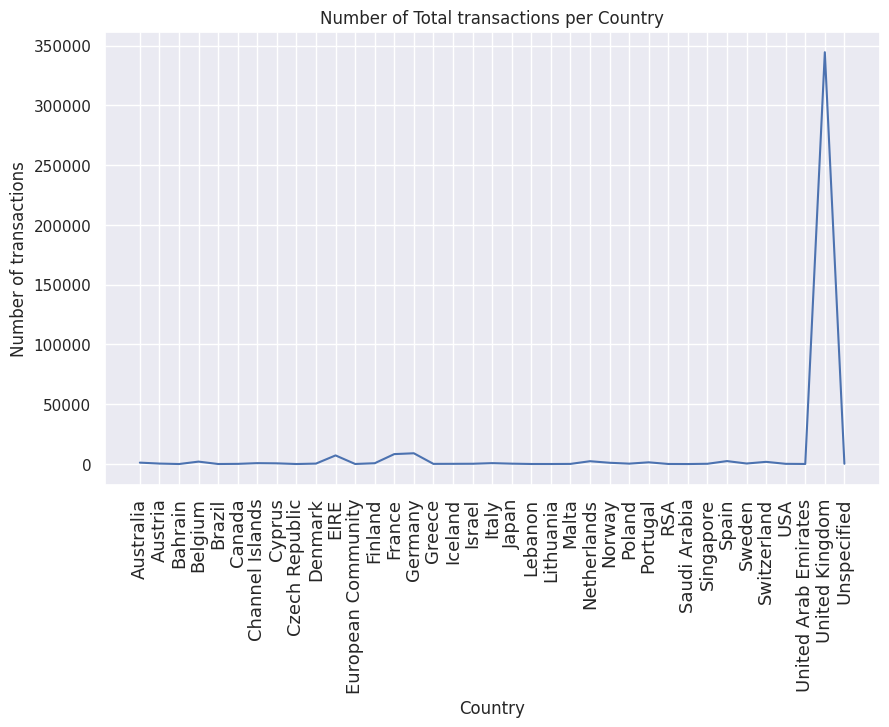

In [110]:
# plot line graph
plt.figure(figsize=(10, 6))
plt.plot(country, count,)
plt.gca().set(title="Number of Total transactions per Country",
              xlabel="Country", ylabel="Number of transactions")
plt.xticks(rotation=90, fontsize=13)
plt.show()

### Lets find number of unique transactions

In [111]:
country = countrywise_transactions.groups.keys()
count = countrywise_transactions["Invoice"].nunique()
percents = (countrywise_transactions["Invoice"].nunique(
)/len(countrywise_transactions["Invoice"].value_counts())*100)

unique_countrywise_transactions = pd.concat([count, percents], axis=1,
                                            keys=["Count", "Percent (%)"]).sort_values(by="Percent (%)", ascending=False).style.background_gradient(cmap="Blues")
unique_countrywise_transactions

,Count,Percent (%)
Country,,
United Kingdom,16648,89.819261
Germany,457,2.465606
France,389,2.098732
EIRE,260,1.402752
Belgium,98,0.528729
Netherlands,95,0.512544
Spain,90,0.485568
Australia,57,0.307526
Portugal,57,0.307526


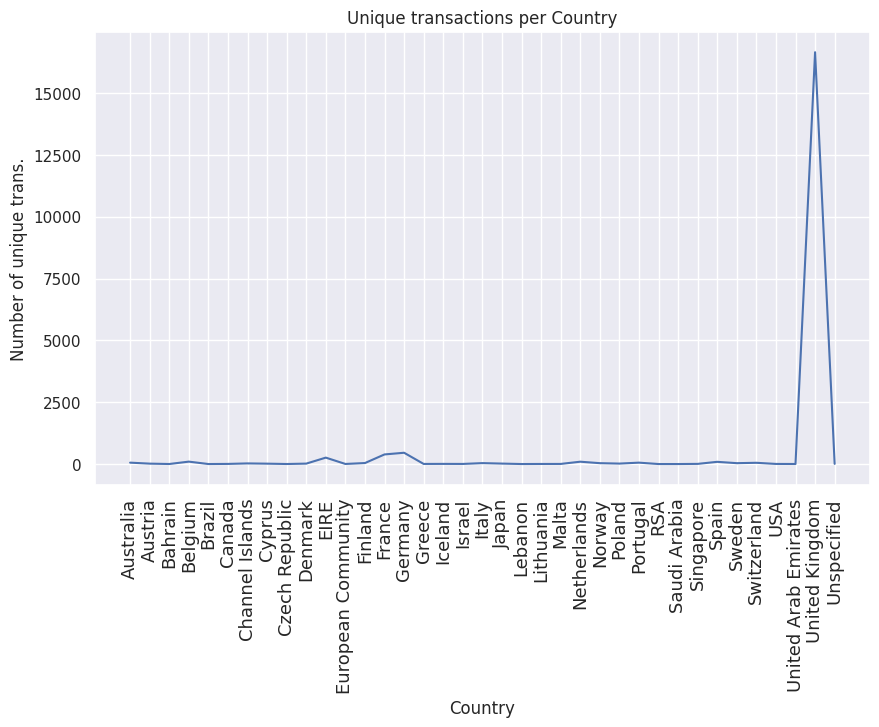

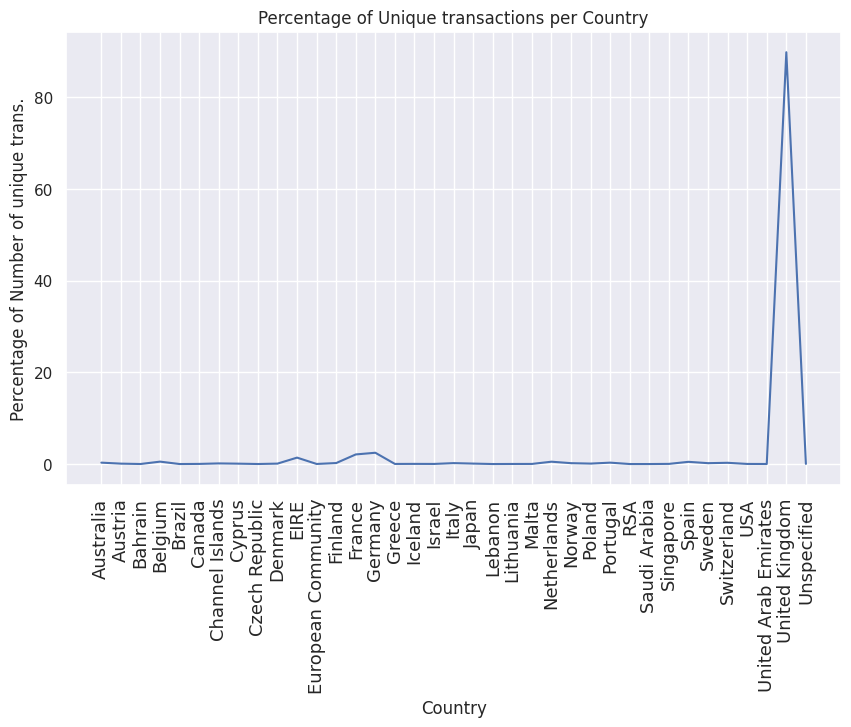

In [112]:
# plot line graph
plt.figure(figsize=(10, 6))
plt.plot(country, count)
plt.gca().set(title="Unique transactions per Country",
              xlabel="Country", ylabel="Number of unique trans.")
plt.xticks(rotation=90, fontsize=13)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(country, percents)
plt.gca().set(title="Percentage of Unique transactions per Country",
              xlabel="Country", ylabel="Percentage of Number of unique trans.")
plt.xticks(rotation=90, fontsize=13)
plt.show()

## Observations:
### United Kingdom 89 % of unique transactions ( 19852 )
### Brazil, Baharin , Lebonan, RSA, Saudi Arabia have made the least number of transactions (1,2, etc)

### UK makes almost 90% of orders , no other country makes near to 3%

## As UK makes 89% of orders ,lets take orders from UK and create new dataframe

In [113]:
df_UK = df[df["Country"] == "United Kingdom"]
display("No of Orders in UK :", df_UK.shape[0])
df_UK.head(3)

'No of Orders in UK :'

344490

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Order_Canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/10 08:26,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,01/12/10 08:26,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/10 08:26,2.75,17850.0,United Kingdom,0


## Unique customers and  products in UK 

In [114]:
unique_UK = df_UK[["Customer ID", "Invoice", "StockCode"]].nunique()
unique_UK

Customer ID     3921
Invoice        16648
StockCode       3645
dtype: int64

## Observations:
### For UK 
#### there are 3950 unique customers
#### 3661  unique products were ordered by UK people
### Multiple transactions exist for each product , some of the transactions may have been canceled.

## Summary Statistics

In [115]:
df_UK.describe()

,Quantity,Price,Customer ID,Order_Canceled
count,344490.000000,344490.000000,344490.000000,344490.0
mean,12.306903,2.980153,15544.557584,0.0
std,193.090805,18.111522,1594.281483,0.0
min,1.000000,0.000000,12346.000000,0.0
25%,2.000000,1.250000,14189.000000,0.0
50%,5.000000,1.950000,15513.000000,0.0
75%,12.000000,3.750000,16931.000000,0.0
max,80995.000000,8142.750000,18287.000000,0.0


### Save data to csv file for further analysis

In [116]:
df_UK.drop("Order_Canceled",axis=1,inplace=True)
df_UK.to_csv("dataUK.csv",index=False)

In [117]:
df_UK_single_transaction = df_UK.groupby(
    ["Customer ID", "Invoice"], as_index=False)["InvoiceDate"].count()
df_UK_single_transaction = df_UK_single_transaction.rename(
    columns={'InvoiceDate': 'Number of Products'})

In [118]:
df_UK_single_transaction

,Customer ID,Invoice,Number of Products
0,12346.0,541431,1
1,12747.0,537215,7
2,12747.0,538537,8
3,12747.0,541677,5
4,12747.0,545321,12
...,...,...,...
16643,18283.0,579673,49
16644,18283.0,580872,50
16645,18287.0,554065,29
16646,18287.0,570715,38
